In [1]:
import pandas as pd
import json
import requests
from urllib.parse import quote
%matplotlib inline 

# Get crime data 
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS Crime_Rate, primary_type AS Primary_Type ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community, Primary_Type LIMIT 10000")

resp = requests.get(soql).json()

crime_type = pd.DataFrame(resp)

In [2]:
# Get rid of the redundant decimal places 
crime_type.Crime_Rate = crime_type.Crime_Rate.astype(float)
crime_type.round(1) 

crime_type.dropna(axis = 0, how = "any", inplace = True) 
crime_type.tail() 

,Community,Crime_Rate,Primary_Type
2022,9,2.6,ROBBERY
2023,9,1.2,SEX OFFENSE
2024,9,0.4,STALKING
2025,9,84.2,THEFT
2026,9,0.2,WEAPONS VIOLATION


In [3]:
crime_type.Primary_Type.value_counts()

ASSAULT                             78
CRIMINAL TRESPASS                   78
DECEPTIVE PRACTICE                  78
OTHER OFFENSE                       78
MOTOR VEHICLE THEFT                 78
NARCOTICS                           78
CRIMINAL DAMAGE                     78
BATTERY                             78
THEFT                               78
WEAPONS VIOLATION                   77
ROBBERY                             77
OFFENSE INVOLVING CHILDREN          77
PUBLIC PEACE VIOLATION              77
LIQUOR LAW VIOLATION                77
SEX OFFENSE                         77
STALKING                            77
ARSON                               77
BURGLARY                            77
CRIM SEXUAL ASSAULT                 77
KIDNAPPING                          76
INTERFERENCE WITH PUBLIC OFFICER    76
HOMICIDE                            75
INTIMIDATION                        75
GAMBLING                            73
PROSTITUTION                        71
OBSCENITY                

In [4]:
# Get socioeconomics data 
socioeconomics = pd.read_csv("data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
# rename "community"
crime_type.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_type['Community Area Number'] = crime_type['Community Area Number'].astype(float)
crime_type.head(15)

,Community Area Number,Crime_Rate,Primary_Type
0,0.0,0.2,ASSAULT
1,0.0,1.2,BATTERY
2,0.0,0.2,CRIMINAL DAMAGE
3,0.0,0.4,CRIMINAL TRESPASS
4,0.0,1.0,DECEPTIVE PRACTICE
5,0.0,0.2,MOTOR VEHICLE THEFT
6,0.0,0.4,NARCOTICS
7,0.0,0.8,OTHER OFFENSE
8,0.0,1.6,THEFT
9,1.0,4.6,ARSON


In [5]:
socioeconomics.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [6]:
crime_df = pd.DataFrame.merge(crime_type, socioeconomics, on = 'Community Area Number')

In [7]:
crime_df.head()

,Community Area Number,Crime_Rate,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,4.6,ARSON,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,1.0,344.8,ASSAULT,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2,1.0,1038.6,BATTERY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
3,1.0,279.6,BURGLARY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
4,1.0,630.6,CRIMINAL DAMAGE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0


In [8]:
# geopandas starts from here

import matplotlib.pyplot as plt
import geopandas as gpd

In [39]:
chicomm_df = gpd.read_file("data/chicomm/chicomm.shp")
# tract_df = tract_df[tract_df["COUNTYFP"] == "031"]
# tract_df.rename(columns = {"NAME" : "Census Tract"}, inplace = True)

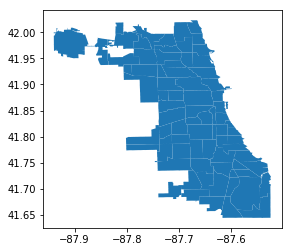

In [40]:
chicomm_df.plot()

In [41]:
chicomm_df.head()

,CHICOMNO,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT,geometry
0,0047,47,Burnside,30179,25946,9025,54900,371,POLYGON ((-87.60019683837891 41.73659896850586...
1,0054,54,Riverdale,7360,6401,3952,46000,115,POLYGON ((-87.61219787597656 41.68529891967773...
2,0001,1,Rogers Park,27330,23902,12603,108400,429,POLYGON ((-87.67801666242399 42.02297966661155...
3,0002,2,West Ridge,36791,31408,14792,127700,491,POLYGON ((-87.70990500473188 42.01177281268769...
4,0003,3,Uptown,22378,19711,12389,137800,378,POLYGON ((-87.65519714354694 41.97660064768972...


In [88]:
chicomm_df_4plot = chicomm_df.copy()

In [43]:
chicomm_df.rename(columns = {'CHICOMNO':'Community Area Number'}, inplace = True)

In [44]:
chicomm_df.set_index('Community Area Number', inplace = True)
# .sort_index(inplace = True)
chicomm_df.index = chicomm_df.index.astype(int)

In [45]:
chicomm_df.sort_index(inplace = True)

In [46]:
chicomm_df.head(20)

,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT,geometry
Community Area Number,,,,,,,,
1,1,Rogers Park,27330,23902,12603,108400,429,POLYGON ((-87.67801666242399 42.02297966661155...
2,2,West Ridge,36791,31408,14792,127700,491,POLYGON ((-87.70990500473188 42.01177281268769...
3,3,Uptown,22378,19711,12389,137800,378,POLYGON ((-87.65519714354694 41.97660064768972...
4,4,Lincoln Square,31403,26344,13091,116600,427,POLYGON ((-87.68979644774656 41.99079895091486...
5,5,North Center,34739,28941,14132,105400,401,POLYGON ((-87.67910003661368 41.96149826121248...
6,6,Lake View,45981,31871,26025,192300,513,POLYGON ((-87.63809967040226 41.94820020171897...
7,7,Lincoln Park,75113,41016,38481,323900,598,POLYGON ((-87.65399932860561 41.93259809608393...
8,8,Near North Side,62715,38684,44537,500001,674,POLYGON ((-87.62899780273439 41.91130064673377...
9,9,Edison Park,49535,41037,18170,137000,526,POLYGON ((-87.81659698482204 42.01860046276523...


In [47]:
chicomm_df.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77],
           dtype='int64', name='Community Area Number')

In [48]:
crime_sum = crime_df.groupby('Community Area Number').sum()

In [49]:
crime_sum.head(20)

,Crime_Rate,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
Community Area Number,,,,,,,,
1.0,5615.4,207.9,637.2,234.9,491.4,742.5,646353,1053.0
2.0,4805.8,218.4,481.6,246.4,582.4,1078.0,645120,1288.0
3.0,5203.2,106.4,672.0,249.2,330.4,621.6,1002036,560.0
4.0,2527.2,88.4,283.4,213.2,348.4,663.0,975624,442.0
5.0,2190.6,7.8,195.0,135.2,117.0,681.2,1485198,156.0
6.0,7731.4,31.9,330.6,136.3,75.4,493.0,1741682,145.0
7.0,5805.4,22.4,344.4,142.8,100.8,602.0,2003428,56.0
8.0,11979.2,55.1,374.1,203.0,72.5,655.4,2571401,29.0
9.0,371.2,25.3,75.9,149.5,170.2,811.9,942057,184.0


In [50]:
crime_sum.index = crime_sum.index.astype(int)

In [51]:
crime_sum_geo = chicomm_df.join(crime_sum)

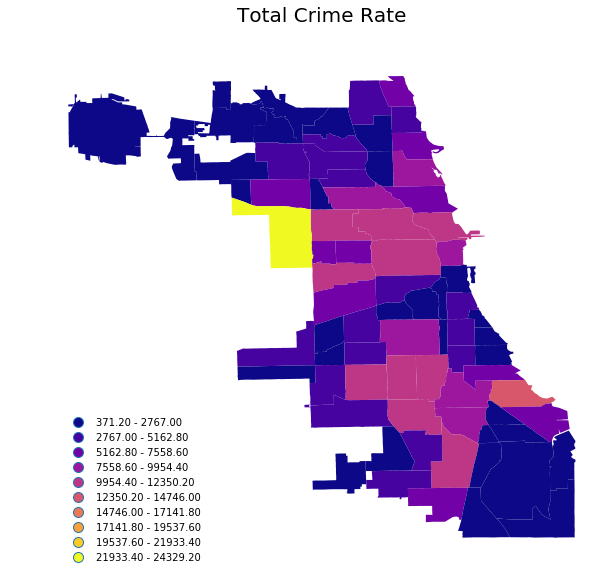

In [52]:
ax_sum = crime_sum_geo.plot(column = 'Crime_Rate', cmap = 'plasma', scheme = 'equal_interval',
                            k = 10, linewidth = 2,
                            legend = True, figsize = (10, 10),
                            )
ax_sum.set_title("Total Crime Rate", fontsize = 20, y = 1.05)
ax_sum.get_legend().set_bbox_to_anchor((0.3, 0.3))
ax_sum.get_legend().get_frame().set_linewidth(0)
ax_sum.set_axis_off()


In [53]:
ax_sum.figure.savefig('Total Crime Rate.png')

In [54]:
crime_sum_geo.head()

,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT,geometry,Crime_Rate,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
Community Area Number,,,,,,,,,,,,,,,,
1,1,Rogers Park,27330,23902,12603,108400,429,POLYGON ((-87.67801666242399 42.02297966661155...,5615.4,207.9,637.2,234.9,491.4,742.5,646353,1053.0
2,2,West Ridge,36791,31408,14792,127700,491,POLYGON ((-87.70990500473188 42.01177281268769...,4805.8,218.4,481.6,246.4,582.4,1078.0,645120,1288.0
3,3,Uptown,22378,19711,12389,137800,378,POLYGON ((-87.65519714354694 41.97660064768972...,5203.2,106.4,672.0,249.2,330.4,621.6,1002036,560.0
4,4,Lincoln Square,31403,26344,13091,116600,427,POLYGON ((-87.68979644774656 41.99079895091486...,2527.2,88.4,283.4,213.2,348.4,663.0,975624,442.0
5,5,North Center,34739,28941,14132,105400,401,POLYGON ((-87.67910003661368 41.96149826121248...,2190.6,7.8,195.0,135.2,117.0,681.2,1485198,156.0


In [103]:
# building interactive map
import folium

m = folium.Map([41.8, -87.8], 
               tiles='cartodbpositron', 
               zoom_start=9.3, max_zoom=17, min_zoom=4)


colormap = folium.LinearColormap(("red", "orange", "yellow", "green",
                                  "blue", "purple"), 
                                 vmin = crime_sum_geo['Crime_Rate'].min(), 
                                 vmax = crime_sum_geo['Crime_Rate'].max(),
                                 caption = 'Total Crime Rate')

colormap.add_to(m)

folium.GeoJson(crime_sum_geo,
               style_function = lambda feature: { 
                  'fillColor': colormap(feature['properties']['Crime_Rate']),
                  "color" : "black", "weight" : 1, "fillOpacity" : 0.55
               }).add_to(m)

m.save("Total_Crime_Rate.html")

m

In [56]:
# create maps for different primary_type
from shapely.geometry import Point

In [57]:
# query BURGLARY's location
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area, primary_type, latitude, longitude ")
# soql += quote("latitude, longtitude ")
soql += quote("WHERE 2007 < year AND year < 2013 AND primary_type = 'BURGLARY' ")
soql += quote("LIMIT 200000 ")

resp = requests.get(soql).json()

crime_type_burglary = pd.DataFrame(resp)

In [58]:
# crime_type_burglary_2 = crime_type_burglary.copy()

In [59]:
crime_type_burglary = crime_type_burglary.dropna()

In [60]:
len(crime_type_burglary)

128214

In [61]:
crime_type_burglary.longitude = crime_type_burglary.longitude.astype(float)
crime_type_burglary.latitude = crime_type_burglary.latitude.astype(float)

In [62]:
geometry = [Point(xy) for xy in zip(crime_type_burglary.longitude, crime_type_burglary.latitude)]
crime_coords_burglary = gpd.GeoDataFrame(crime_type_burglary,
                                crs = {'init': 'epsg:4269'}, geometry=geometry)

In [63]:
# remove irrelevant points
crime_coords_burglary = crime_coords_burglary[crime_coords_burglary.latitude > 40]

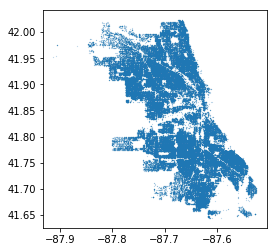

In [64]:
crime_coords_burglary.plot(markersize = 0.01)

In [89]:
chicomm_df_4plot

,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT,geometry
index_right,,,,,,,,
1,1,Rogers Park,27330,23902,12603,108400,429,POLYGON ((-87.67801666242399 42.02297966661155...
2,2,West Ridge,36791,31408,14792,127700,491,POLYGON ((-87.70990500473188 42.01177281268769...
3,3,Uptown,22378,19711,12389,137800,378,POLYGON ((-87.65519714354694 41.97660064768972...
4,4,Lincoln Square,31403,26344,13091,116600,427,POLYGON ((-87.68979644774656 41.99079895091486...
5,5,North Center,34739,28941,14132,105400,401,POLYGON ((-87.67910003661368 41.96149826121248...
6,6,Lake View,45981,31871,26025,192300,513,POLYGON ((-87.63809967040226 41.94820020171897...
7,7,Lincoln Park,75113,41016,38481,323900,598,POLYGON ((-87.65399932860561 41.93259809608393...
8,8,Near North Side,62715,38684,44537,500001,674,POLYGON ((-87.62899780273439 41.91130064673377...
9,9,Edison Park,49535,41037,18170,137000,526,POLYGON ((-87.81659698482204 42.01860046276523...


In [74]:
located_bulglary = gpd.sjoin(crime_coords_burglary, chicomm_df_4plot, how = 'left', op = 'within')

In [75]:
located_bulglary.head()

,community_area,latitude,longitude,primary_type,geometry,index_right,CHICOMNO,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT
173,28,41.886808,-87.643860,BURGLARY,POINT (-87.64385962999999 41.886808021),28.0,0028,28.0,Near West Side,10628.0,9336.0,8306.0,121900.0,218.0
174,23,41.895878,-87.706567,BURGLARY,POINT (-87.706566627 41.895877613),22.0,0023,23.0,Humboldt Park,21296.0,20038.0,6905.0,53300.0,332.0
175,44,41.730201,-87.608711,BURGLARY,POINT (-87.608710996 41.730200847),44.0,0044,44.0,Chatham,29258.0,24008.0,12292.0,67800.0,382.0
176,31,41.855795,-87.679560,BURGLARY,POINT (-87.679560016 41.85579548),31.0,0031,31.0,Lower West Side,22128.0,20571.0,6467.0,44300.0,231.0
177,7,41.916142,-87.635751,BURGLARY,POINT (-87.635751106 41.916141557),8.0,0007,7.0,Lincoln Park,75113.0,41016.0,38481.0,323900.0,598.0


In [112]:
burglary_chicomm_count = located_bulglary.groupby("community_area").count()
burglary_chicomm_count.head()

,latitude,longitude,primary_type,geometry,index_right,CHICOMNO,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT
community_area,,,,,,,,,,,,,
1,1394,1394,1394,1394,1386,1386,1386,1386,1386,1386,1386,1386,1386
10,574,574,574,574,566,566,566,566,566,566,566,566,566
11,564,564,564,564,564,564,564,564,564,564,564,564,564
12,453,453,453,453,431,431,431,431,431,431,431,431,431
13,711,711,711,711,703,703,703,703,703,703,703,703,703


In [113]:
burglary_chicomm_count = burglary_chicomm_count[["index_right"]].rename(columns = {"index_right" : "BURGLARY"})

In [114]:
burglary_chicomm_count.index = burglary_chicomm_count.index.astype(int)

In [115]:
chicomm_df_4plot.rename(columns = {'DISTNAME':'community_area'}, inplace = True)

In [116]:
chicomm_df_4plot.community_area

index_right
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
      ..
48    48
49    49
50    50
51    51
52    52
53    53
54    54
55    55
56    56
57    57
58    58
59    59
60    60
61    61
62    62
63    63
64    64
65    65
66    66
67    67
68    68
69    69
70    70
71    71
72    72
73    73
74    74
75    75
76    76
77    77
Name: community_area, Length: 77, dtype: int64

In [117]:
mapped_burglary = pd.merge(chicomm_df_4plot, burglary_chicomm_count, how = "inner", left_on = "community_area", right_index = True)

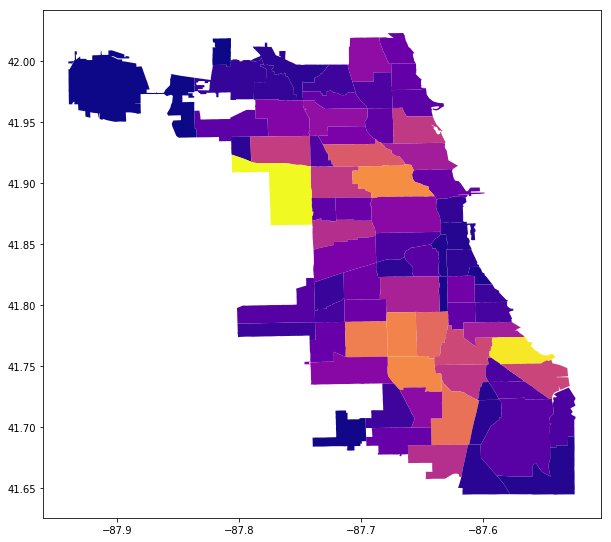

In [124]:
mapped_burglary.plot(column = "BURGLARY", cmap = "plasma", k = 9, linewidth = 0,
                    figsize = (10, 10) )

In [125]:
crime_bulglary = crime_df[crime_df['Primary_Type'] == 'BURGLARY']
crime_bulglary.set_index('Community Area Number', inplace = True)
crime_bulglary = crime_bulglary.sort_index()
crime_bulglary.head()

,Crime_Rate,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
Community Area Number,,,,,,,,,,
1.0,279.6,BURGLARY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2.0,401.4,BURGLARY,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
3.0,227.2,BURGLARY,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
4.0,186.2,BURGLARY,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
5.0,240.2,BURGLARY,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [128]:
# merge primary_type with community geodata
crime_bulglary_geo = chicomm_df.join(crime_bulglary)
crime_bulglary_geo.head()

,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT,geometry,Crime_Rate,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
index_right,,,,,,,,,,,,,,,,,,
1,1,Rogers Park,27330,23902,12603,108400,429,POLYGON ((-87.67801666242399 42.02297966661155...,279.6,BURGLARY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2,2,West Ridge,36791,31408,14792,127700,491,POLYGON ((-87.70990500473188 42.01177281268769...,401.4,BURGLARY,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
3,3,Uptown,22378,19711,12389,137800,378,POLYGON ((-87.65519714354694 41.97660064768972...,227.2,BURGLARY,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
4,4,Lincoln Square,31403,26344,13091,116600,427,POLYGON ((-87.68979644774656 41.99079895091486...,186.2,BURGLARY,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
5,5,North Center,34739,28941,14132,105400,401,POLYGON ((-87.67910003661368 41.96149826121248...,240.2,BURGLARY,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


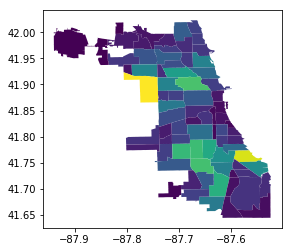

In [131]:
crime_bulglary_geo.plot(column = 'Crime_Rate')

In [ ]:
geometry = [Point(xy) for xy in zip(crime_bulglary_geo.Longitude, mix_df.Latitude)]
crime_coords = gpd.GeoDataFrame(mix_df,
                                crs = {'init': 'epsg:4269'}, geometry=geometry)